In [4]:
# Standard imports
# If any of these don't work, try doing `pip install _____`, or try looking up the error message.
import numpy as np
import pandas as pd
import json
import time
import os.path
from os import path
import math
import datetime
import unidecode
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

# Part 1: Pandas Mini-Lesson

# First, read 10 minutes to pandas, linked here!
https://pandas.pydata.org/docs/getting_started/10min.html#min

### Then, do these quick exercises

In [5]:
years = [2015, 2016, 2017, 2018]
stats = ['pts', 'reb', 'ast']
data = np.array([
    [20, 10, 5],
    [21, 23, 12],
    [15, 13, 8],
    [38, 15, 15]
])

#TODO: make a pandas df with the years as indeces and the stats as columns with the data

df = pd.DataFrame(data, index = years, columns = stats)
df

,pts,reb,ast
2015,20,10,5
2016,21,23,12
2017,15,13,8
2018,38,15,15


In [6]:
#Todo: re-sort your data to go from most current stats at the top to older stats at the bottom
df = df.sort_index(ascending = False)

#Todo: rearrange the columns to go ast, pts, reb
new_order = ['ast', 'pts', 'reb']
df = df[new_order]
df

,ast,pts,reb
2018,15,38,15
2017,8,15,13
2016,12,21,23
2015,5,20,10


In [7]:
#Todo: make df2 only the points and rebounds categories for 2016-2018
df2 = df.iloc[0:3, 1:3]
df2

,pts,reb
2018,38,15
2017,15,13
2016,21,23


##### Part 2: K-Means Cluster Model

### step 1: getting data, splitting into train + test data

In [8]:
#Accessing the data from csv, convering to pandas df

data = pd.read_csv("data/player_data_final.csv")
data.head()

,name,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,...,NCAAB_two_point_percentage,NCAAB_win_shares,NBA_assists,NBA_blocks,NBA_points,NBA_steals,NBA_total_rebounds,Center,Forward,Guard
0,Landry Fields,89.0,25.0,506.0,0.490,248.0,0.508,257.0,0.696,179.0,...,0.521,6.0,155.0,17.0,797.0,80.0,521.0,0,0,1
1,Andy Rautins,171.0,8.0,297.0,0.438,130.0,0.273,81.0,0.815,66.0,...,0.571,4.9,3.0,0.0,8.0,1.0,1.0,0,0,1
2,Patrick Patterson,36.0,51.0,374.0,0.575,215.0,0.348,130.0,0.692,90.0,...,0.626,7.0,41.0,37.0,328.0,17.0,200.0,0,1,0
3,Gani Lawal,15.0,49.0,325.0,0.529,172.0,0.683,222.0,0.572,127.0,...,0.531,4.1,0.0,0.0,0.0,0.0,0.0,0,1,0
4,Cole Aldrich,31.0,125.0,265.0,0.562,149.0,0.600,159.0,0.679,108.0,...,0.562,5.9,4.0,7.0,18.0,5.0,35.0,1,0,0


In [9]:
#setting names to index

data.set_index('name', inplace=True)
data.head()

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_two_point_percentage,NCAAB_win_shares,NBA_assists,NBA_blocks,NBA_points,NBA_steals,NBA_total_rebounds,Center,Forward,Guard
name,,,,,,,,,,,,,,,,,,,,,
Landry Fields,89.0,25.0,506.0,0.490,248.0,0.508,257.0,0.696,179.0,32.0,...,0.521,6.0,155.0,17.0,797.0,80.0,521.0,0,0,1
Andy Rautins,171.0,8.0,297.0,0.438,130.0,0.273,81.0,0.815,66.0,35.0,...,0.571,4.9,3.0,0.0,8.0,1.0,1.0,0,0,1
Patrick Patterson,36.0,51.0,374.0,0.575,215.0,0.348,130.0,0.692,90.0,38.0,...,0.626,7.0,41.0,37.0,328.0,17.0,200.0,0,1,0
Gani Lawal,15.0,49.0,325.0,0.529,172.0,0.683,222.0,0.572,127.0,36.0,...,0.531,4.1,0.0,0.0,0.0,0.0,0.0,0,1,0
Cole Aldrich,31.0,125.0,265.0,0.562,149.0,0.600,159.0,0.679,108.0,36.0,...,0.562,5.9,4.0,7.0,18.0,5.0,35.0,1,0,0


In [10]:
#standardizing dataframe
data.mean()
zeroed = data - data.mean()
standardized = zeroed / zeroed.std()
standardized.head()

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_two_point_percentage,NCAAB_win_shares,NBA_assists,NBA_blocks,NBA_points,NBA_steals,NBA_total_rebounds,Center,Forward,Guard
name,,,,,,,,,,,,,,,,,,,,,
Landry Fields,0.080437,-0.098580,1.286229,0.128398,1.465264,0.611038,1.834461,-0.344055,1.466673,-0.302348,...,0.002967,0.765109,1.237825,0.262920,1.971745,2.421417,3.251170,-0.262896,-0.878735,1.000952
Andy Rautins,1.452384,-0.737524,-0.563826,-0.694436,-0.804858,-1.005699,-1.122902,0.823571,-0.909686,0.323405,...,0.831642,0.103656,-0.563354,-0.630667,-0.739031,-0.748367,-0.784998,-0.262896,-0.878735,1.000952
Patrick Patterson,-0.806310,0.878629,0.117773,1.473416,0.830399,-0.489719,-0.299545,-0.383303,-0.404972,0.949158,...,1.743184,1.366429,-0.113059,1.314199,0.360396,-0.106386,0.759613,-0.262896,1.135832,-0.997146
Gani Lawal,-1.157662,0.803459,-0.315972,0.745524,0.003151,1.814992,1.246349,-1.560741,0.373127,0.531990,...,0.168702,-0.377400,-0.598903,-0.630667,-0.766517,-0.788491,-0.792760,-0.262896,1.135832,-0.997146
Cole Aldrich,-0.889965,3.659917,-0.847088,1.267707,-0.439330,1.243974,0.187748,-0.510859,-0.026437,0.531990,...,0.682480,0.704977,-0.551504,-0.262720,-0.704674,-0.587872,-0.521094,3.796534,-0.878735,-0.997146


In [11]:
#changing the order of the columns to make it easier to drop the nba columns for our training set

new_order = standardized.columns[::-1]
standardized = standardized[new_order]
new_order

Index(['Guard', 'Forward', 'Center', 'NBA_total_rebounds', 'NBA_steals',
       'NBA_points', 'NBA_blocks', 'NBA_assists', 'NCAAB_win_shares',
       'NCAAB_two_point_percentage', 'NCAAB_two_point_attempts',
       'NCAAB_turnovers', 'NCAAB_turnover_percentage', 'NCAAB_total_rebounds',
       'NCAAB_total_rebound_percentage', 'NCAAB_three_point_attempts',
       'NCAAB_three_point_attempt_rate', 'NCAAB_steals',
       'NCAAB_steal_percentage', 'NCAAB_points', 'NCAAB_personal_fouls',
       'NCAAB_height', 'NCAAB_games_started', 'NCAAB_games_played',
       'NCAAB_free_throws', 'NCAAB_free_throw_percentage',
       'NCAAB_free_throw_attempts', 'NCAAB_free_throw_attempt_rate',
       'NCAAB_field_goals', 'NCAAB_field_goal_percentage',
       'NCAAB_field_goal_attempts', 'NCAAB_blocks', 'NCAAB_assists'],
      dtype='object')

In [12]:
#saving nba data
data = data[new_order]
test = data.iloc[:, 3:8]
test.head()

,NBA_total_rebounds,NBA_steals,NBA_points,NBA_blocks,NBA_assists
name,,,,,
Landry Fields,521.0,80.0,797.0,17.0,155.0
Andy Rautins,1.0,1.0,8.0,0.0,3.0
Patrick Patterson,200.0,17.0,328.0,37.0,41.0
Gani Lawal,0.0,0.0,0.0,0.0,0.0
Cole Aldrich,35.0,5.0,18.0,7.0,4.0


In [13]:
#removing nba data from training data
nba_cols = new_order[3:8]
train = standardized.drop(nba_cols, axis = 1)
train.head()

,Guard,Forward,Center,NCAAB_win_shares,NCAAB_two_point_percentage,NCAAB_two_point_attempts,NCAAB_turnovers,NCAAB_turnover_percentage,NCAAB_total_rebounds,NCAAB_total_rebound_percentage,...,NCAAB_games_played,NCAAB_free_throws,NCAAB_free_throw_percentage,NCAAB_free_throw_attempts,NCAAB_free_throw_attempt_rate,NCAAB_field_goals,NCAAB_field_goal_percentage,NCAAB_field_goal_attempts,NCAAB_blocks,NCAAB_assists
name,,,,,,,,,,,,,,,,,,,,,
Landry Fields,1.000952,-0.878735,-0.262896,0.765109,0.002967,1.884504,0.541649,-0.643611,0.928749,0.530785,...,-0.302348,1.466673,-0.344055,1.834461,0.611038,1.465264,0.128398,1.286229,-0.098580,0.080437
Andy Rautins,1.000952,-0.878735,-0.262896,0.103656,0.831642,-2.259574,1.134077,2.373809,-0.941814,-1.207580,...,0.323405,-0.909686,0.823571,-1.122902,-1.005699,-0.804858,-0.694436,-0.563826,-0.737524,1.452384
Patrick Patterson,-0.997146,1.135832,-0.262896,1.366429,1.743184,0.575248,-1.117150,-1.501776,0.963389,0.111902,...,0.949158,-0.404972,-0.383303,-0.299545,-0.489719,0.830399,1.473416,0.117773,0.878629,-0.806310
Gani Lawal,-0.997146,1.135832,-0.262896,-0.377400,0.168702,0.791560,0.344173,0.352968,1.217416,1.263830,...,0.531990,0.373127,-1.560741,1.246349,1.814992,0.003151,0.745524,-0.315972,0.803459,-1.157662
Cole Aldrich,-0.997146,-0.878735,3.796534,0.704977,0.682480,0.119855,-0.524722,0.020775,1.783204,1.766489,...,0.531990,-0.026437,-0.510859,0.187748,1.243974,-0.439330,1.267707,-0.847088,3.659917,-0.889965


### step 2: PCA (dimension reduction)

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2)
pca_fitted = pca.fit_transform(train.values)

In [16]:
print("Ratios:", list(pca.explained_variance_ratio_))
print("Total explained by components:", sum(pca.explained_variance_ratio_))

Ratios: [0.3060633625482498, 0.24094947243735088]
Total explained by components: 0.5470128349856007


In [17]:
names = list(train.index)
pd.DataFrame(data = pca_fitted, index = names).head()

,0,1
Landry Fields,2.444185,-2.583910
Andy Rautins,2.280511,3.687858
Patrick Patterson,-1.366987,-2.556470
Gani Lawal,-2.491334,-3.265399
Cole Aldrich,-3.641889,-3.982227


### step 3: K-means
<img src = "https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/02/k-means-sagemaker-1.gif" align = left> 

In [18]:
from sklearn.cluster import KMeans

In [19]:
#fitting the model. can adjust the number of clusters
k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(train.values)
k_means_cluster

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=120, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
def plot_cluster(data, labels):
    plt.figure(figsize=(18, 9))
    plt.scatter(data[:, 0], data[:, 1], color=plt.cm.Set1(np.true_divide(np.array(labels), max(labels))))

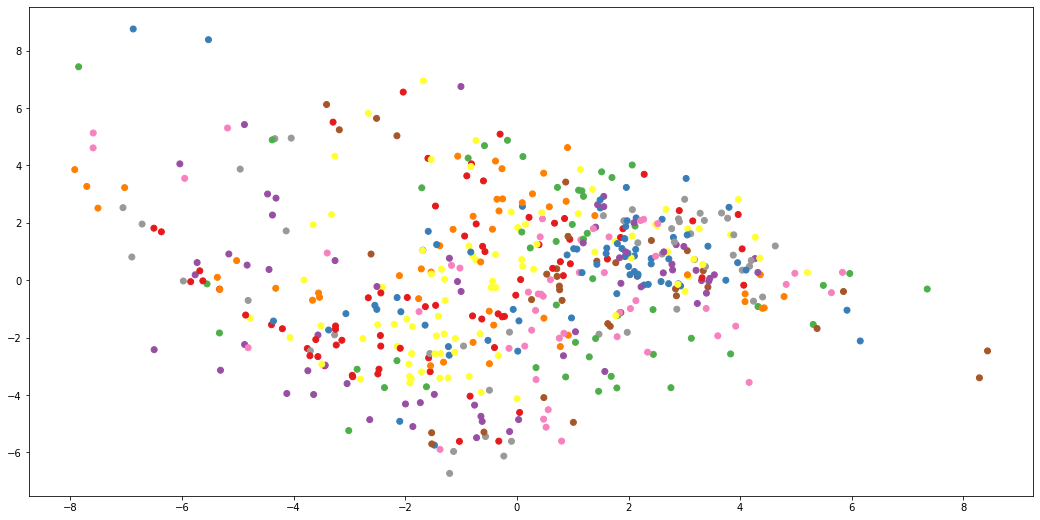

In [21]:
"""plots the pca'd version of our data into different colored clusters. This isn't really helpful bc
we can only plot 2 dimensions, and we have 28"""
plot_cluster(pca_fitted, k_means_cluster.labels_)

### step 4: testing

In [22]:
player = 'Trae Young'

In [23]:
#add label column to see what cluster each player was placed in

train['label'] = k_means_cluster.labels_
train.head()

,Guard,Forward,Center,NCAAB_win_shares,NCAAB_two_point_percentage,NCAAB_two_point_attempts,NCAAB_turnovers,NCAAB_turnover_percentage,NCAAB_total_rebounds,NCAAB_total_rebound_percentage,...,NCAAB_free_throws,NCAAB_free_throw_percentage,NCAAB_free_throw_attempts,NCAAB_free_throw_attempt_rate,NCAAB_field_goals,NCAAB_field_goal_percentage,NCAAB_field_goal_attempts,NCAAB_blocks,NCAAB_assists,label
name,,,,,,,,,,,,,,,,,,,,,
Landry Fields,1.000952,-0.878735,-0.262896,0.765109,0.002967,1.884504,0.541649,-0.643611,0.928749,0.530785,...,1.466673,-0.344055,1.834461,0.611038,1.465264,0.128398,1.286229,-0.098580,0.080437,28
Andy Rautins,1.000952,-0.878735,-0.262896,0.103656,0.831642,-2.259574,1.134077,2.373809,-0.941814,-1.207580,...,-0.909686,0.823571,-1.122902,-1.005699,-0.804858,-0.694436,-0.563826,-0.737524,1.452384,0
Patrick Patterson,-0.997146,1.135832,-0.262896,1.366429,1.743184,0.575248,-1.117150,-1.501776,0.963389,0.111902,...,-0.404972,-0.383303,-0.299545,-0.489719,0.830399,1.473416,0.117773,0.878629,-0.806310,79
Gani Lawal,-0.997146,1.135832,-0.262896,-0.377400,0.168702,0.791560,0.344173,0.352968,1.217416,1.263830,...,0.373127,-1.560741,1.246349,1.814992,0.003151,0.745524,-0.315972,0.803459,-1.157662,1
Cole Aldrich,-0.997146,-0.878735,3.796534,0.704977,0.682480,0.119855,-0.524722,0.020775,1.783204,1.766489,...,-0.026437,-0.510859,0.187748,1.243974,-0.439330,1.267707,-0.847088,3.659917,-0.889965,46


In [24]:
"""drop the player we are looking for from the dataset, since we don't wanna use their data to predict them
Then, returning the players in the same cluster as the given player"""
player_label = train.loc[player].label
player_label
similar = train[train.label == player_label]
similar.drop(index=player, inplace=True) # Don't want to take player's actual results in prediction
similar

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Guard,Forward,Center,NCAAB_win_shares,NCAAB_two_point_percentage,NCAAB_two_point_attempts,NCAAB_turnovers,NCAAB_turnover_percentage,NCAAB_total_rebounds,NCAAB_total_rebound_percentage,...,NCAAB_free_throws,NCAAB_free_throw_percentage,NCAAB_free_throw_attempts,NCAAB_free_throw_attempt_rate,NCAAB_field_goals,NCAAB_field_goal_percentage,NCAAB_field_goal_attempts,NCAAB_blocks,NCAAB_assists,label
name,,,,,,,,,,,,,,,,,,,,,
Nolan Smith,1.000952,-0.878735,-0.262896,1.606958,-0.328502,1.713731,1.923981,0.214555,-0.387573,-0.914362,...,1.634911,0.803947,1.380775,-0.097574,1.696124,-0.377961,1.835049,-0.925449,1.753543,31
Bryce Cotton,1.000952,-0.878735,-0.262896,1.186033,-1.157177,0.962332,0.620639,-0.782025,-0.872533,-1.312300,...,2.455070,1.196427,1.968887,0.439045,1.118974,-0.995087,1.666862,-0.925449,2.021241,31
Pierre Jackson,1.000952,-0.878735,-0.262896,1.366429,-0.510811,0.074316,2.081962,0.657479,-0.745520,-1.123803,...,1.740059,0.676392,1.548807,0.377127,0.849638,-0.868497,1.286229,-1.038204,2.857794,31


In [25]:

nba_data = test
nba_data['Guard'] = standardized['Guard'] # Adding positions for curiousity
nba_data['Forward'] = standardized['Forward'] # Adding positions for curiousity
nba_data['Center'] = standardized['Center'] # Adding positions for curiousity
similar_nba = nba_data.loc[similar.index]
similar_nba

,NBA_total_rebounds,NBA_steals,NBA_points,NBA_blocks,NBA_assists,Guard,Forward,Center
name,,,,,,,,
Nolan Smith,56.0,18.0,167.0,3.0,62.0,1.000952,-0.878735,-0.262896
Bryce Cotton,18.0,4.0,80.0,0.0,15.0,1.000952,-0.878735,-0.262896
Pierre Jackson,9.0,2.0,35.0,0.0,19.0,1.000952,-0.878735,-0.262896


In [26]:
avg = similar_nba.mean()
avg_stats = avg[:5] / 25
season_stats = pd.concat((avg_stats, pd.Series({'NBA_games_played': avg[5]}))).round(2)
season_stats

NBA_total_rebounds    1.11
NBA_steals            0.32
NBA_points            3.76
NBA_blocks            0.04
NBA_assists           1.28
NBA_games_played      1.00
dtype: float64

In [27]:
print ("We predict that", player, "will average", str(season_stats['NBA_points']), "points,", str(season_stats['NBA_total_rebounds']), "rebounds,", str(season_stats['NBA_assists']), "assists,", str(season_stats['NBA_steals']), "steals,", str(season_stats['NBA_blocks']), "blocks per game, and play in", 25, "games in his rookie season.")

We predict that Trae Young will average 3.76 points, 1.11 rebounds, 1.28 assists, 0.32 steals, 0.04 blocks per game, and play in 25 games in his rookie season.
